# Logistic Regression
## Problem
Given a dataset, predict if it will rain tomorrow.
1. This is a classification problem.
2. If want to use regression, then the response variable need to be a numeric value.
3. One way to do it is to consider the probability of rain tomorrow as a dependent variable.
4. However this will result the predicted probability of the model can be greater than 1 or less than 0.
5. Hence, use odds ratio as dependent variable. (Logistic Regression)

## Linear Regression v.s. Logistic Regression
Logistic Regression is fit for classification problem.
### Classifiaction Problem
Assign input into classes, but in dataset have the 'true' classification (hence supervised)
Use logistic regression to solve classifiaction problems.
- Take linear convination
- Apply sigmoid function to the result so that the output in between 0 and 1
- Cross entropy as loss function
### Regression Problem
Assign input to get a continuous value.
Use linear regression to solve regression problems.

## ML Workflow
1. initialize model
2. pass input into model to obtain predictions
3. compare predictions with actual targets with loss function
4. optimization
5. repeat until model is considered to be good enough

## Load Data

In [43]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [44]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


To see the data in Data folder:

In [45]:
import os

In [46]:
os.listdir('Data')

['weatherAUS.csv']

To load the data:

In [47]:
import pandas as pd

In [48]:
raw_df = pd.read_csv('Data/weatherAUS.csv')

Check demsion and basic info of the dataset:

In [49]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

See that some of the column has null value, RainTomorrow need to be treated carefully as it is the thing we want to predict. It is not a good solution to fill in the missing value in this field, better solution is to consider null value as own class or just simply delete null. Similar for RainToday value as it is very likely to be very close related with the response.

In [50]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

For other missing values, have many ways:
- Can fill in the average if the feature is normally distributed
- Can delete null if null value is not many
- Can check the correlation and simply don't include that feature in the model

## Basic Analysis and Visualization

In [51]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
px.histogram(raw_df, x='Location', title='Location v.s. Rainy Days', color='RainToday')

In [ ]:
px.histogram(raw_df, x='Temp3pm', title='Temperature at 3 pm vs. Rain Tomorrow', color='RainTomorrow')

In [ ]:
px.histogram(raw_df, x='RainTomorrow', color='RainToday', title='Rain Tomorrow vs. Rain Today')

In [ ]:
px.scatter(raw_df.sample(2000), title='Temp (3 pm) vs. Humidity (3 pm)', x='Temp3pm', y='Humidity3pm',
           color='RainTomorrow')

Location follows a uniform distribution, Temp3pm follow a normal distribution, and RainTomorrow seems strongly correlated with Location, Temp3pm, and RainToday. However, Humidity 3pm seems positively correlated with RainTomorrow.

In [ ]:
px.histogram(raw_df, x='Date', title='RainTomorrow v.s. Date', color='RainToday')

See that not strongly correlated with Date.

In [ ]:
px.scatter(raw_df.sample(2000), title='MinTemp vs. MaxTemp', x='MinTemp', y='MaxTemp',
           color='RainTomorrow')

See that if RainTomorrow, Max Temp tend to be lower.

In [ ]:
px.histogram(raw_df, x='Rainfall', title='RainTomorrow v.s. Rainfall', color='RainToday')

Seems that Rainfall can be used, but need to take further calculation as the plot is squeezed very much around 0.

In [ ]:
px.histogram(raw_df, x='Evaporation', title='Evaporation v.s. Rain Tomorrow', color='RainToday')

In [ ]:
px.histogram(raw_df, x='Sunshine', title='Sunshine v.s. Rain Tomorrow', color='RainToday')

Sunshine are expected to have high correlation with the dependent value.

In [ ]:
sns.violinplot(data=raw_df, x='Sunshine', y='RainTomorrow')

In [ ]:
sns.violinplot(data=raw_df, x='WindSpeed9am', y='RainTomorrow')

In [ ]:
sns.violinplot(data=raw_df, x='WindSpeed3pm', y='RainTomorrow')

In [ ]:
px.histogram(raw_df, x='WindDir9am', title='WindDir v.s. Rain Tomorrow', color='RainToday')

In [ ]:
px.histogram(raw_df, x='WindDir3pm', title='WindDir v.s. Rain Tomorrow', color='RainToday')

In [ ]:
px.scatter(raw_df.sample(2000), title='Humidity', x='Humidity9am', y='Humidity3pm',
           color='RainTomorrow')

Seems Humidity at any time can have reasonable strong correlation.

In [ ]:
px.scatter(raw_df.sample(2000), title='Pressure', x='Pressure9am', y='Pressure3pm',
           color='RainTomorrow')

In [ ]:
sns.violinplot(data=raw_df, x='Cloud9am', y='RainTomorrow')

In [ ]:
sns.violinplot(data=raw_df, x='Cloud3pm', y='RainTomorrow')

Seems cloud also have high correlation to the prediction.
## Working with a Sample

In [59]:
use_sample = False

In [60]:
sample_fraction = 0.1

In [61]:
if use_sample:
    raw_df = raw_df.sample(frac=sample_fraction).copy()

## Training, Validation and Test Sets
- Training set: to train the model
- Validation set: to evaluate the model during the training
- Test set: to test the model after training to see if model overfit

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
training_val_df, testing_df = train_test_split(raw_df, test_size=0.2, random_state=42)
training_df, val_df = train_test_split(training_val_df, test_size=0.25, random_state=42)

If deal with dates, it's often better idea to separate the training, validation and test sets with time, so model can train on data former to the testing data.

In [54]:
year = pd.to_datetime(raw_df.Date).dt.year

training_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
testing_df = raw_df[year > 2015]

## Feature Filtering
For example, as stated above, Date column can be ignored

In [55]:
x_col = list(training_df.columns)[1:-1]
y_col = 'RainTomorrow'

In [56]:
training_x = training_df[x_col].copy()
training_y = training_df[y_col].copy()

In [57]:
validating_x = val_df[x_col].copy()
validating_y = val_df[y_col].copy()

In [58]:
testing_x = testing_df[x_col].copy()
testing_y = testing_df[y_col].copy()

Determine if the columns are numerical or categorical:

In [59]:
import numpy as np

In [60]:
numeric_cols = training_x.select_dtypes(include=np.number).columns.tolist()
categorical_cols = training_x.select_dtypes('object').columns.tolist()

In [61]:
training_x[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.000000,97801.000000,97988.000000,61657.000000,57942.000000,91160.000000,97114.000000,96919.000000,96936.000000,96872.000000,88876.000000,88857.000000,63000.000000,61966.000000,97414.000000,97392.000000
mean,12.007831,23.022202,2.372935,5.289991,7.609004,40.215873,14.092263,18.764608,68.628745,51.469547,1017.513734,1015.132352,4.302952,4.410677,16.835126,21.540138
std,6.347175,6.984397,8.518819,3.952010,3.788813,13.697967,8.984203,8.872398,19.003097,20.756113,7.072510,6.997072,2.866634,2.693370,6.404586,6.831612
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000
25%,7.500000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.800000,1010.400000,1.000000,2.000000,12.200000,16.600000
50%,11.800000,22.400000,0.000000,4.600000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.500000,1015.100000,5.000000,5.000000,16.600000,20.900000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.300000,1019.900000,7.000000,7.000000,21.400000,26.200000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000


In [62]:
training_x[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Missing Values
One way to deal with the missing value is to filling them.
Here use the basic one: fill with average value:

In [63]:
from sklearn.impute import SimpleImputer

In [64]:
imputer = SimpleImputer(strategy = 'mean')

In [65]:
raw_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

In [66]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

In [67]:
training_x[numeric_cols] = imputer.transform(training_x[numeric_cols])
validating_x[numeric_cols] = imputer.transform(validating_x[numeric_cols])
testing_x[numeric_cols] = imputer.transform(testing_x[numeric_cols])

In [68]:
# check
training_x[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## Scaling Numeric Features
As stated in Linear Regression, it is often better to scale the numeric features:

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler()
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

In [71]:
# check
print(f'Minimum: {list(scaler.data_min_)}\nMaximum: {list(scaler.data_max_)}')

Minimum: [-8.5, -4.8, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 980.5, 977.1, 0.0, 0.0, -7.2, -5.4]
Maximum: [33.9, 48.1, 371.0, 145.0, 14.5, 135.0, 130.0, 87.0, 100.0, 100.0, 1041.0, 1039.6, 9.0, 9.0, 40.2, 46.7]


Repeat this on train/validation/test dataset:

In [72]:
training_x[numeric_cols] = scaler.transform(training_x[numeric_cols])
validating_x[numeric_cols] = scaler.transform(validating_x[numeric_cols])
testing_x[numeric_cols] = scaler.transform(testing_x[numeric_cols])

In [73]:
# check
training_x[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000
mean,0.483689,0.525947,0.006396,0.036949,0.525366,0.265107,0.108395,0.215668,0.686309,0.514693,0.612014,0.608705,0.483192,0.493693,0.507089,0.517103
std,0.149458,0.131904,0.022962,0.021628,0.200931,0.102420,0.068800,0.101424,0.189008,0.206376,0.111335,0.106611,0.255486,0.238028,0.134722,0.130726
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030400,0.000000,0.000000,0.027426,0.005758
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,0.543802,0.540800,0.333333,0.333333,0.409283,0.422265
50%,0.478774,0.514178,0.000000,0.037741,0.526244,0.255814,0.100000,0.218391,0.690000,0.520000,0.614125,0.610527,0.492351,0.499917,0.502110,0.506718
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,0.682645,0.675200,0.666667,0.666667,0.601266,0.604607
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988484


## Encoding Categorical Data
Similar to Linear Regression, one of the easiest way to use categorical data in regression is by dummy variables. Hence need to encode them:

In [74]:
from sklearn.preprocessing import OneHotEncoder

In [75]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [76]:
encoder.fit(raw_df[categorical_cols])
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

Then generate column names for each individual category:

In [77]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

training_x[encoded_cols] = encoder.transform(training_x[categorical_cols])
validating_x[encoded_cols] = encoder.transform(validating_x[categorical_cols])
testing_x[encoded_cols] = encoder.transform(testing_x[categorical_cols])

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [78]:
# check
testing_x

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037741,0.526244,ENE,0.372093,NaN,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037741,0.526244,SSE,0.341085,SSE,SE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037741,0.526244,ENE,0.325581,ESE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037741,0.526244,SSE,0.255814,SE,SSE,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,Albury,0.566038,0.523629,0.018329,0.037741,0.526244,ENE,0.193798,SE,SSE,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,0.283019,0.502836,0.000000,0.037741,0.526244,E,0.193798,ESE,E,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145455,Uluru,0.266509,0.533081,0.000000,0.037741,0.526244,E,0.193798,SE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145456,Uluru,0.285377,0.568998,0.000000,0.037741,0.526244,NNW,0.124031,SE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145457,Uluru,0.327830,0.599244,0.000000,0.037741,0.526244,N,0.240310,SE,WNW,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Save Data
Since dataset is large, it would be better to save it on disk:

In [79]:
# !pip install pyarrow --quiet

In [80]:
training_x.to_parquet('training_x.parquet')
validating_x.to_parquet('validating_x.parquet')
testing_x.to_parquet('testing_x.parquet')

In [81]:
%%time
pd.DataFrame(training_y).to_parquet('training_y.parquet')
pd.DataFrame(validating_y).to_parquet('validating_y.parquet')
pd.DataFrame(testing_y).to_parquet('testing_y.parquet')

Wall time: 23.9 ms


Then Dataframe can be loaded by:

In [82]:
%%time

training_x = pd.read_parquet('training_x.parquet')
validating_x = pd.read_parquet('validating_x.parquet')
testing_x = pd.read_parquet('testing_x.parquet')

training_y = pd.read_parquet('training_y.parquet')[y_col]
validating_y = pd.read_parquet('validating_y.parquet')[y_col]
testing_y = pd.read_parquet('testing_y.parquet')[y_col]

Wall time: 93.8 ms


## Training Logistic Regression Model
- Take linear combination
- apply sigmoid function to result so that it is within 0 to 1
- represent probability
- use cross entropy loss function

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
model = LogisticRegression(solver='liblinear')
model.fit(training_x[numeric_cols + encoded_cols], training_y)

LogisticRegression(solver='liblinear')

In [85]:
# can check the coefficients and intercepts
# model.coef_
# model.intercept_

## Evaluate the Model
Use the validating dataset to validate the model.

In [86]:
y_hat_training = model.predict(training_x[numeric_cols + encoded_cols])

We can get probabilities, 0 is probability for "No" and 1 "Yes":

In [87]:
model.predict_proba(training_x[numeric_cols + encoded_cols])

array([[0.94401162, 0.05598838],
       [0.94074175, 0.05925825],
       [0.96093635, 0.03906365],
       ...,
       [0.98749116, 0.01250884],
       [0.98334683, 0.01665317],
       [0.87453444, 0.12546556]])

Also can check:

In [88]:
model.classes_

array(['No', 'Yes'], dtype=object)

For this classification problem, we can get accuracy. Also can visualize it by confusion matrix. (Note that accuracy is not always good for determine a model is good or bad)

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(training_y, y_hat_training)

0.8519206433440829

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
confusion_matrix(training_y, y_hat_training, normalize='true')

array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

In [93]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 85.19%


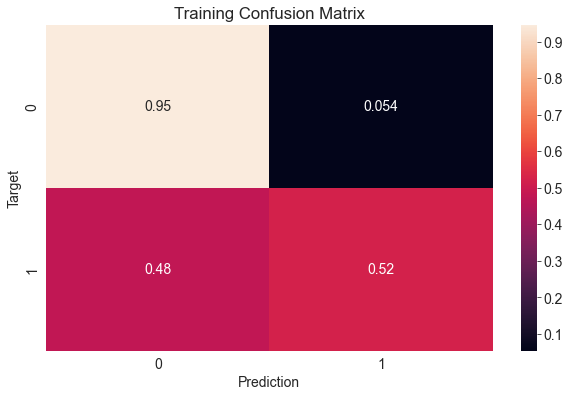

In [94]:
y_hat_training = predict_and_plot(
    training_x[numeric_cols + encoded_cols], training_y, 'Training')

Accuracy: 85.40%


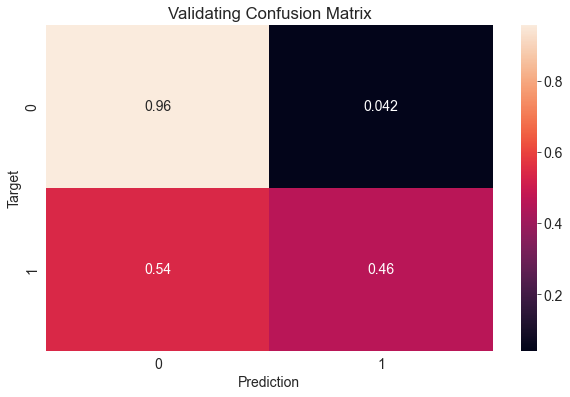

In [95]:
y_hat_validating = predict_and_plot(
    validating_x[numeric_cols + encoded_cols], validating_y, 'Validating')

Accuracy: 84.20%


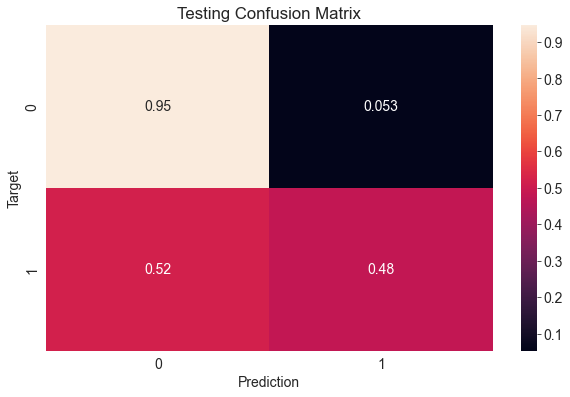

In [96]:
y_hat_testing = predict_and_plot(
    testing_x[numeric_cols + encoded_cols], testing_y, 'Testing')

Seems good fit to unseen data. But as stated above, does accuracy necessary a good measure of fit of the model? See following examples:

In [97]:
def random_guess(inputs):
    return np.random.choice(["No", "Yes"], len(inputs))

In [98]:
def all_no(inputs):
    return np.full(len(inputs), "No")

In [99]:
accuracy_score(testing_y,
               random_guess(testing_x[numeric_cols + encoded_cols]))

0.49918319719953325

In [100]:
accuracy_score(testing_y,
               all_no(testing_x[numeric_cols + encoded_cols]))

0.7734344612991054

See that second (all no) model gives accuracy of 77.3%. This value could be higher if dataset is more unbalanced in dependent variable.

Train with only numeric features:

In [101]:
model_numeric = LogisticRegression(solver='liblinear').fit(
    training_x[numeric_cols], training_y)

accuracy_score(testing_y,
               model_numeric.predict(testing_x[numeric_cols]))

0.8385453131077402

Which gives higher accuracy.

Train with categorical feature:

In [102]:
model_categorical = LogisticRegression(solver='liblinear').fit(
    training_x[encoded_cols], training_y)

accuracy_score(testing_y,
               model_categorical.predict(testing_x[encoded_cols]))

0.7779852197588487

Which give similar accuracy.

## Single Input

In [103]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [105]:
new_input_df = pd.DataFrame([new_input])

In [106]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [107]:
X_new_input = new_input_df[numeric_cols + encoded_cols]

In [108]:
model.predict(X_new_input)[0]

'Yes'

Can use a helper function:

In [109]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

## Saving and Loading Trained Models

In [110]:
import joblib

In [112]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': x_col,
    'target_col': y_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [113]:
# save
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

In [114]:
# load
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [116]:
test_preds2 = aussie_rain2['model'].predict(testing_x[numeric_cols + encoded_cols])
accuracy_score(testing_y, test_preds2)

0.8420070011668611

## Putting together
I've attach course material into a folder putting together all codes.